# Extração de Features e Construção do Modelo

### 1. Introdução a Extração de Features
- A extração de features é uma parte muito importante na análise e na identificação de relações entre diferentes elementos. Como já sabemos, os dados de áudio não podem ser compreendidos diretamente pelos modelos, então precisamos convertê-los para um formato inteligível, e é para isso que a extração de features é utilizada.


#### Com a taxa de amostragem e os dados do sinal, podemos realizar diversas transformações para extrair características valiosas do áudio. No entanto, neste projeto, não vamos aprofundar no processo de seleção de features para identificar quais são mais relevantes para o nosso dataset. Em vez disso, vamos extrair cinco features principais para treinar nosso modelo:
- **Zero Crossing Rate (ZCR):** Mede a taxa de mudanças de sinal no áudio, ou seja, quantas vezes ele cruza o eixo zero em um determinado intervalo de tempo. Essa feature é útil para distinguir sons percussivos e não percussivos.
- **Chroma STFT:** Representa a energia espectral em 12 bins correspondentes às notas da escala musical ocidental. Essa característica é útil para identificar padrões harmônicos no áudio.
- **MFCC (Mel-Frequency Cepstral Coefficients):** Converte a frequência do áudio para a escala mel, aproximando-se da percepção auditiva humana. É uma das features mais utilizadas em reconhecimento de fala e emoção.
- **RMS (Root Mean Square):** Mede a energia do sinal ao calcular a média quadrática das amplitudes do áudio. Essa feature ajuda a representar a intensidade do som.
- **Mel Spectrogram:** Representa a distribuição de energia do áudio em diferentes faixas de frequência na escala mel, capturando informações espectrais essenciais.

### 1.1. Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np

import pickle
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2025-05-01 15:13:34.126022: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 15:13:34.129706: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 15:13:34.141013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746123214.159856    9868 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746123214.165343    9868 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746123214.179752    9868 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### 1.2. Carregar o Dataframe da EDA 

In [28]:
data_path = "/home/vinicius/Desktop/miniprojeto2/data/ravdess_preprocessed.csv" 
df = pd.read_csv(data_path)

In [29]:
df.tail()

,Emotions,Path,Processed_Path
1435,disgust,/home/vinicius/Desktop/miniprojeto2/raw/Actor_...,/home/vinicius/Desktop/miniprojeto2/data/proce...
1436,surprise,/home/vinicius/Desktop/miniprojeto2/raw/Actor_...,/home/vinicius/Desktop/miniprojeto2/data/proce...
1437,sad,/home/vinicius/Desktop/miniprojeto2/raw/Actor_...,/home/vinicius/Desktop/miniprojeto2/data/proce...
1438,happy,/home/vinicius/Desktop/miniprojeto2/raw/Actor_...,/home/vinicius/Desktop/miniprojeto2/data/proce...
1439,calm,/home/vinicius/Desktop/miniprojeto2/raw/Actor_...,/home/vinicius/Desktop/miniprojeto2/data/proce...


### 2. Criando uma função para extração das features

##### Fizemos essa parte no notebook passado, então você pode copiar e colar o código das funções aqui, pois precisaremos delas:

In [30]:
def noise(data):
    n = np.random.normal(0, data.std(), data.size) # cria um vetor com ruído branco 
    return data + n # retorna o áudio com ruido

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate) # retonra um áudio com velocidade alterada

def shift(data):
    return np.roll(data, np.random.random(1, len(data))) # retorna um vetor de audio com os dados deslocados aleatoriamente

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor) # retorna um audio com a frequência alterada

# Tomando um áudio qualquer com exemplo
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

##### Aqui você deve extrair essas features de fato... mais tarde você precisará delas :)

# **Funções usadas**

### **vstack()**: concatena dois arrays numpy por linha e gera uma matriz

[1, 2, 3] e [4, 5, 6] -> [[1, 2, 3,]
                          [4, 5, 6,]]  

### **hstack()**: concatena pela coluna e gera uma matriz.

[1, 2, 3] e [4, 5, 6] -> [[1, 2, 3, 4, 5, 6]]  


### **zero.crossings()**: calcula quantos ZCR existem em um áudio.  
- Retorna um array numpy de **tamanho igual ao vetor de áudio**, em que cada elemento indica se **passou pelo eixo X ou não** 
- **Parâmetros**: (audio, pad=False), pan=False deixa de contar com o primeiro valor do array audio[0]  
  
### **chroma_stft()** retorna o espectograma de notas  
- **Parâmetros**: (audio, sample rate)
- Com o espectograma, é possível descobrir a tonalidade de uma música
- Para descobrir quantos existem em um áudio: utilizar a função sum  

 ### **np.mean()**: Para cada feature, é necessário reduzir sua dimensão, pois a função hstack só aceita arrays com o mesmo numero de linhas (). Para isso, tomamos a média dos valores de cada feature para jogar no ML


# **Escala mel**: escala que tenta simular numericamente a percepção humana do som
- Mudanças de sons em baixa frequência são mais fáceis de serem percebidos, mas mudança em sons de alta frequência quase não percebemos

### **.mfcc()**: retorna um áudio em escala mel para cada frame do áudio 
- **Parâmetros**: (audio, sr, n_mfcc)
 - **n_mfcc** é a quantidade de dados que iremos tomar sobre o audio na escala mel. Tomamos 13 porque já são suficientes para detectar padrões e é um bom número para treinar modelos de machine learning com desempenho  

### **.melspectogram()**: retorna um array com o espectograma do áudio em escala mel


In [31]:
def extract_features(data, sample_rate): 
    result = np.array([])
    # zcr
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data, pad=False), axis=1)
    result = np.hstack((result, zcr))

    # Chroma_stft
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate), axis=1)
    result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate), axis=1) # n_mfcc = 20, pois com 20 amostras já é possível detectar padrões no áudio 
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data, frame_length=2048, hop_length=512), axis=1)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr = sample_rate), axis=1)
    result = np.hstack((result, mel))
    
    return result # retorna um array com 1x162, em que cada coluna é o dado de uma feaure 

def get_features(path):
    # Carregar áudio
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Sem aumento de dados
    res1 = extract_features(data, sample_rate)  
    result = np.array(res1)

    # Com ruído
    noise_data = noise(data) # aplica áudio com ruído
    res2 = extract_features(noise_data, sample_rate)  
    result = np.vstack((result, res2))

    # Com alongamento e mudança de pitch
    new_data = stretch(data) # altera o tempo
    data_stretch_pitch = pitch(new_data, sample_rate) # altera a afinação (pitch) 
    res3 = extract_features(data_stretch_pitch, sample_rate) 
    result = np.vstack((result, res3)) # result é o empilhamento de linhas de todos as features
    
    return result # retorna um array 3x162, em que todas as linhas representam o mesmo áudio e as linhas são as features desse áudio 

##### Rode as células abaixo

## Ideia do código:  
   
1° Itera em cada linha do dataset capturando o path do áudio e a emoção associada.  

2° Chama a função que captura as features de um áudio
- A função retorna uma matriz 3x162, em que **a primeira linha é o áudio normal, a segunda é o áudio com ruído e a terceira é o áudio com alteração no pitch+stretch**
- As colunas são as 5 features associadas a cada áudio  

3° Adiciona cada linha, ou seja, cada **informação sobre a feature** na lista X

4° Adiciona a emoção associada a essa feature na lista Y


Assim, cada elemento de X se relaciona com sua respectiva emoção salva em Y. Exemplo:  

X = [ [1, 2, 3, 4, 5], [4, 3, 1, 6, 7], [7, 8, 6, 4, 1], [4, 3, 2, 1, 5], [12, 34, 66, 88, 11], [32, 14, 53, 67, 12] ]  

Y = [ 'fear', 'fear', 'fear', 'happy', 'happy', 'happy']

In [32]:
# X salva as features do áudio
# Y salva as emoções associadas as features
X, Y = [], []

# zip retorna uma dupla em que cada elemento é uma dupla: um de path e outro de emotions
for path, emotion in zip(df['Path'], df['Emotions']):
    feature = get_features(path) # retorna um array 3x162 [ [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5] ]

    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [33]:
# essa linha retorna uma tupla que informa o tamanho de X, Y, número de áudios
len(X), len(Y), df.Path.shape

(4320, 4320, (1440,))

##### Agora você deverá salvar o csv de features (features.csv)

## **Explicação do código**:

Após extrair X e Y, temos as informações de cada feature associada a uma única emoção. Agora, a ideia é criar um DataSet em que cada linha contenha as features de um áudio e sua respectiva emoção 

In [34]:
# os.path.dirname() retorna o nome de um diretório
# os.getcwd() retorna o diretório pai 
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data") # acessa o diretório pai na pasta 'data'
os.makedirs(data_dir, exist_ok=True)

# armazena a informação de onde será salvo o CSV criado
csv_path = os.path.join(data_dir, "features.csv")

# Crie um DataFrame do pandas chamado Features usando a lista X.
Features = pd.DataFrame(X)

# Transformando Y em um dataset com uma única coluna
labels = pd.DataFrame(Y, columns=['labels'])

# Concatenando o dataset labels a features
Features = pd.concat([Features, labels], axis=1)

# Salve o DataFrame como um arquivo CSV no caminho definido, sem incluir o índice, definindo _index_=False
Features.to_csv(csv_path, index=False)


print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: /home/vinicius/Desktop/miniprojeto2/data/features.csv


In [35]:
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.238449,0.494891,0.474462,0.332266,0.331190,0.339100,0.349193,0.384328,0.450196,0.476845,...,0.001865,0.001613,0.001542,0.001590,0.001572,0.001468,0.001524,0.000913,8.202936e-05,fear
1,0.414103,0.722722,0.699077,0.628086,0.626512,0.607741,0.535242,0.521779,0.553874,0.571807,...,0.212777,0.196042,0.183440,0.202218,0.192023,0.208727,0.211861,0.202115,1.976549e-01,fear
2,0.220855,0.373287,0.519008,0.472378,0.315185,0.313234,0.298754,0.275199,0.355760,0.467056,...,0.000564,0.000562,0.000407,0.000377,0.000348,0.000472,0.000338,0.000274,3.435445e-05,fear
3,0.240148,0.339819,0.357354,0.402665,0.415448,0.486580,0.552078,0.354643,0.349146,0.352472,...,0.002150,0.004248,0.005924,0.004535,0.004361,0.003670,0.002869,0.002482,2.871481e-04,fear
4,0.417991,0.531086,0.580057,0.617404,0.666578,0.673327,0.742290,0.612915,0.479018,0.448518,...,0.028456,0.032081,0.033845,0.030974,0.034898,0.032986,0.032670,0.031333,3.038724e-02,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0.396860,0.550422,0.565553,0.584306,0.608592,0.554600,0.511907,0.483717,0.459956,0.504071,...,0.047529,0.049611,0.050014,0.048983,0.049046,0.044718,0.044968,0.046421,4.669840e-02,happy
4316,0.153516,0.327807,0.354101,0.345151,0.387222,0.382491,0.333419,0.330528,0.349080,0.306704,...,0.000260,0.000182,0.000197,0.000230,0.000199,0.000236,0.000223,0.000142,1.058883e-05,happy
4317,0.173964,0.416651,0.363161,0.355355,0.439302,0.516752,0.515909,0.412584,0.450408,0.592608,...,0.000014,0.000011,0.000016,0.000014,0.000012,0.000015,0.000012,0.000006,4.779550e-07,calm
4318,0.403081,0.556848,0.611696,0.585730,0.618613,0.669793,0.650473,0.564528,0.524365,0.611286,...,0.000586,0.000563,0.000573,0.000557,0.000544,0.000558,0.000561,0.000549,5.396194e-04,calm


### 2.1. Data Preparation (Preparação dos Dados)

# **Funções usadas:**  

### **.iloc()**: serve para selecionar linhas e colunas específicas de um dataframe. Exemplo:  
- .iloc[0:10, -1]: seleciona as linhas de 0 a 4 da última coluna. Usa-se a vírgula para separar linha/coluna 
- .iloc[0, :-1]: seleciona a primeira linha de todas as colunas menos a última  
- **Retorno**: **uma series pandas**


### **.get_dummies()**: serve para transformar um array numpy em dados categoricos
- **Parâmetros**: (array numpy, dtype=int)

In [218]:
# seleciona todas as linhas da primeira até a penultima coluna
# aplica .values para que cada elemento de X seja uma linha do dataset 
X = Features.iloc[: ,:-1].values 

# Retorna todos os dados de labels em um array
Y = Features['labels'].values

In [219]:
# Use OneHotEncoder para transformar o Y em uma representação binária categórica, necessária para problemas de classificação multiclasse
encoder = OneHotEncoder(sparse_output=False)
Y_reshaped = np.array(Y).reshape(-1, 1)
Y = encoder.fit_transform(Y_reshaped)

### **train_test_split**: divide cada matriz passada em duas: dados para teste e dados para treino  

- **Parâmetros**: (matriz1, matriz2, ..., train_size=, test_size=)
- Divide **ALEATORIAMENTE** quais dados usará no conjunto teste ou treino
- Mesmo passando duas matrizes, ela vai dividir as **mesmas linhas**


In [220]:
# Use train_test_split do scikit-learn para dividir X e Y em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15) # divide em 15% dos dados para teste e 85% para treino


### **StandardScaler**: é uma fórmula para normalizar os dados:

z = (X - média da coluna de X) / desvio padrão de X  

**.fit()**: calcula o novo valor para os dados  
  
**.transform()**: aplica a transformação de valores  

Em X_test não é necessário usar o .fit(), pois o calculo ja foi feito anteriormente, so basta aplicá-lo com transform

In [221]:
# Utilize StandardScaler do sklearn para normalizar as características de X
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train.shape, X_test.shape

((3672, 162), (648, 162))

In [222]:
# Rode essa célula para deixar as dimensões certinhas com o modelo que iremos criar.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3672, 162, 1), (3672, 8), (648, 162, 1), (648, 8))

### 3. Model Training (Modelling)

#### O modelo que vamos usar é uma rede neural convolucional (CNN) projetada para processar os dados extraídos dos arquivos de áudio. Essa estrutura é ideal para capturar padrões espectrais, como variações de tom e intensidade. A CNN é composta por:
- Camadas Convolucionais (Conv1D): Extraem características do espectro do áudio.
- Camadas de Pooling (MaxPooling1D): Reduzem a dimensionalidade e capturam as informações mais relevantes.
- Dropout: Ajuda a evitar overfitting.
- Camada Flatten: Transforma os mapas de features em um vetor de entrada para a camada totalmente conectada.
- Camadas Densas (Dense): Realizam a classificação final usando a função de ativação softmax.

Uma imagem é uma grande matriz. Em que cada ponto é uma cor RGB. Assim, computar todos os pontos dessa matriz é algo extremamente custoso.  

A rede CNN **tenta extrair as características mais importantes em uma imagem**. Exemplo, ao se deparar com a imagem de ondas sonoras de um áudio, tenta computar somente as partes que as ondas aparecem  

# **Funções usadas:**  

### **keras.sequential()**: a rede CNN utilizada possui uma única entrada. A função serve para escrever camadas em Redes desse tipo  

### **keras.layers.Conv1D()**: cria uma camada de CNN para 1 dimensão  

Em uma rede CNN, é importante saber quais áreas da imagem são as mais importantes:  
### **keras.layers.MaxPooling1D** é a função que reduz a imagem na CNN  

## **keras.layers.Dropout**: elimina aleatoriamente algumas conexões da rede de CNN
- O objetivo é impedir o **Overffiting**, pois, ao eliminar conexões, diminui a probabilidade de o modelo estar excessivamente treinado com seus próprios dados 
- mais infos: https://medium.com/@csediveyanand/what-is-dropout-in-keras-deep-learning-c2d0913439f3

### **keras.Flatten**: ao entrar com imagens de diferentes dimensões, o Flatten as converte para um array unidimensional  
- Isso acontece para que o modelo só precise de um único neurônio de entrada
- mais infos: https://kevinmlean.medium.com/how-to-use-keras-layers-flatten-c3f29ed1b686

In [223]:
# Dica: você pode olhar a documentação e ir seguindo o passo a passo arquitetônico para criar o modelo.

# Passo 1: Use Sequential() para criar o modelo como um contêiner linear.
# Passo 2: Adicione uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 3: Siga com uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 4: Adicione mais uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 5: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 6: Adicione mais uma camada Conv1D com 128 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 7: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 8: Adicione uma camada Dropout com 0.2 de taxa de dropout.
# Passo 9: Adicione mais uma camada Conv1D com 64 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 10: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 11: Adicione uma camada Flatten.
# Passo 12: Adicione uma camada Dense com 32 unidades e função de ativação 'relu'.
# Passo 13: Adicione uma camada Dropout com 0.3 de taxa de dropout.
# Passo 14: Adicione uma camada Dense com 8 unidades e função de ativação 'softmax'.
# Passo 15: Compile o modelo com otimizador 'adam', loss 'categorical_crossentropy' e métrica 'accuracy'.
# Passo 16: Use model.summary() para visualizar o modelo.

modelo = keras.Sequential( # passo 1
    [
     keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu',input_shape=(162, 1)), #neurônio de entrada # passo 2
     keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'), # passo 3
     #keras.layers.Dropout(rate=0.2), # passo 8
     keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'), # passo 9
     keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'), # passo 10
     keras.layers.Dropout(rate=0.2), # passo 8
     keras.layers.Flatten(), # passo 11
     keras.layers.Dense(units=32,activation='relu'), # passo 12
     keras.layers.Dropout(rate=0.3), # passo 13
     keras.layers.Dense(units=8,activation='softmax')
    ]
)

# adam é um otimizador para atualizar os pesos durante o treino
# loss é a função de perda, ou seja, o que o modelo deve minizar (diferença entre o previsto e o real)
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #passo 15
modelo.summary() #passo 16

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 81, 64)         │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │        84,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,784 (655.41 KB)

 Trainable params: 167,784 (655.41 KB)

 Non-trainable params: 0 (0.00 B)

### 3.1. Agora vamos de fato treinar o modelo, siga esses passos: 
##### 1. Use o callback para Ajustar a Taxa de Aprendizado 
##### ReduceLROnPlateau: Diminui a taxa de aprendizado quando uma métrica está estagnada.
   Parâmetros:
   - monitor='loss': Monitora a perda durante o treinamento.
   - factor=0.4: Reduz a taxa de aprendizado por este fator.
   - patience=2: Número de épocas sem melhora antes da redução.
   - min_lr=0.0000001: Limite mínimo para a taxa de aprendizado.
             
##### 2. Treine o Modelo 
##### Utilize model.fit para iniciar o treino da rede neural.
   Parâmetros:
   - x_train, y_train: Conjunto de dados de treino.
   - batch_size=64: Número de amostras por atualização de gradiente.
   - epochs=50: Número de vezes que o modelo treina em todo o conjunto de dados.
   - validation_data=(x_test, y_test): Conjunto de dados para validação durante o treino.
   - callbacks=[rlrp]: Lista de callbacks a serem aplicados durante o treino.
     

In [224]:
history = modelo.fit(
    X_train, Y_train, batch_size=64, epochs=50, validation_data= (X_test,Y_test),
    callbacks=[ReduceLROnPlateau(monitor= 'loss', factor= 0.4, patience= 2, min_lr= 0.0000001)])

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.2029 - loss: 1.9841 - val_accuracy: 0.2716 - val_loss: 1.8543 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2719 - loss: 1.8612 - val_accuracy: 0.3287 - val_loss: 1.7632 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3040 - loss: 1.7916 - val_accuracy: 0.3488 - val_loss: 1.7461 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3318 - loss: 1.7544 - val_accuracy: 0.3781 - val_loss: 1.6793 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3332 - loss: 1.7339 - val_accuracy: 0.3765 - val_loss: 1.6563 - learning_rate: 0.0010
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3666 - loss: 1.6601 - val_accuracy: 0.3750 - val_loss: 1.6350 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3464 - loss: 1.6689 - val_acc

### 3.2. Avaliar e Visualizar a Performance do Modelo

##### Passo 1: Avaliando o Modelo
- **Precisão nos Dados de Teste**:
  - Use `model.evaluate(x_test, y_test)` para calcular a precisão do modelo no conjunto de teste.

##### Passo 2: Preparando os Gráficos
- **Definindo Épocas**:
  - Crie uma lista de épocas para o eixo x
- **Configurando o Layout do Gráfico**:
  - Use `fig, ax = plt.subplots(1, 2)` para criar dois gráficos lado a lado.

##### Passo 3: Plotando a Perda
- **Gráfico de Perda**:
  - Plote a perda de treino e teste:
    ```python
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ```

##### Passo 4: Plotando a Precisão
- **Gráfico de Precisão**:
  - Plote a precisão de treino e teste:
    ```python
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ```

##### Objetivos:
  - **Perda**: Ajuda a identificar se o modelo está treinando bem ou se há overfitting.
  - **Precisão**: Mostra o quão eficaz é o treinamento do modelo em acertar as previsões.


## **Funções usadas**  

### **.evaluate()**: método que retorna a função de perda e a acurácia de um modelo  

- Função de perda: mede o grau de "proximidade" dos valores preditos com os valores reais. Isso permite prever a confiabilidade de um modelo para todos os dados

- **Parâmetos**: recebe o dataset de treino  

- **Retorno**: loss function e metrica escolhida  

### **history.history**: retorna um dicionario contendo os dados do modelo por época  
- **Validação**: Durante o treinamento, testa-se o desempenho do modelo com dados que ele nunca viu
- **teste**: dados separados do dataset para servir como teste de desempenho do modelo


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6352 - loss: 1.1314


<Figure size 1500x500 with 0 Axes>

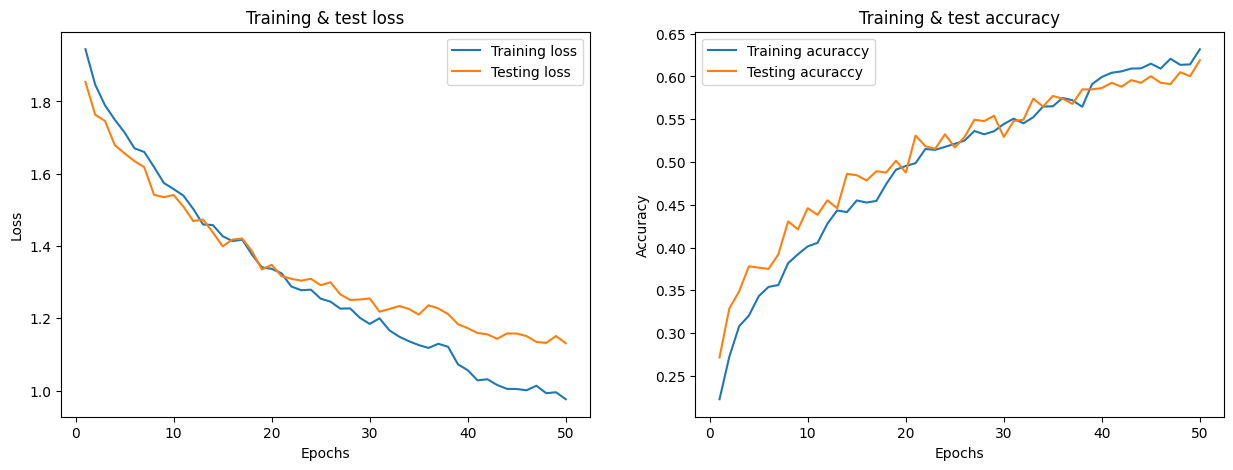

In [225]:
loss, accuracy = modelo.evaluate(X_test, Y_test) # retorna a acurácia e perda geral do modelo 

plt.figure(figsize=(15, 5))

epochs = list(range(1, 51)) # cria lista com o numero de epocas

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# gráficos de perda
train_loss = history.history['loss'] # loss nos dados de treino por época
test_loss = history.history['val_loss'] # loss nos dados de teste por época 

ax[0].plot(epochs, train_loss, label='Training loss')
ax[0].plot(epochs, test_loss, label='Testing loss')

ax[0].set_title('Training & test loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend() # adiciona legenda

# gráficos de acurácia
train_acc = history.history['accuracy'] # accuracy por epoca no treino
teste_acc = history.history['val_accuracy'] # accuracy por epoca no teste

ax[1].plot(epochs, train_acc, label='Training acuraccy')
ax[1].plot(epochs, teste_acc, label='Testing acuraccy')

ax[1].set_title('Training & test accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend() # adiciona legenda

### 3.3. Chegou a parte boa! vamos prever os valores nos dados de teste
- Passo 1: Use model.predict() no x_test e salve o resultado em pred_test.
- Passo 2: Crie y_pred a partir de pred_test usando inverse_transform do encoder (Precisamos converter as previsões codificadas do One-Hot de volta aos rótulos originais)
- Passo 3: Faça o mesmo para os rótulos de teste (y_test), decodificando-os de volta aos rótulos originais.

In [226]:
pred_test = modelo.predict(X_test) # retorna um array informando as probabilidades para cada emoção

y_pred = encoder.inverse_transform(pred_test)

Y_test = encoder.inverse_transform(Y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [227]:
# Rode essa célula para ver se o modelo que criamos está fazendo sentido para a maioria dos valores.

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = Y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,disgust
1,angry,angry
2,angry,angry
3,angry,angry
4,calm,calm
5,surprise,surprise
6,happy,happy
7,disgust,disgust
8,angry,happy
9,angry,angry


### 3.4. Plotar Matriz de Confusão
- Agora tenho um desafio para você, eu quero que você crie uma matriz de confusão que relacione os resultados preditos com os valores reais das emoções!

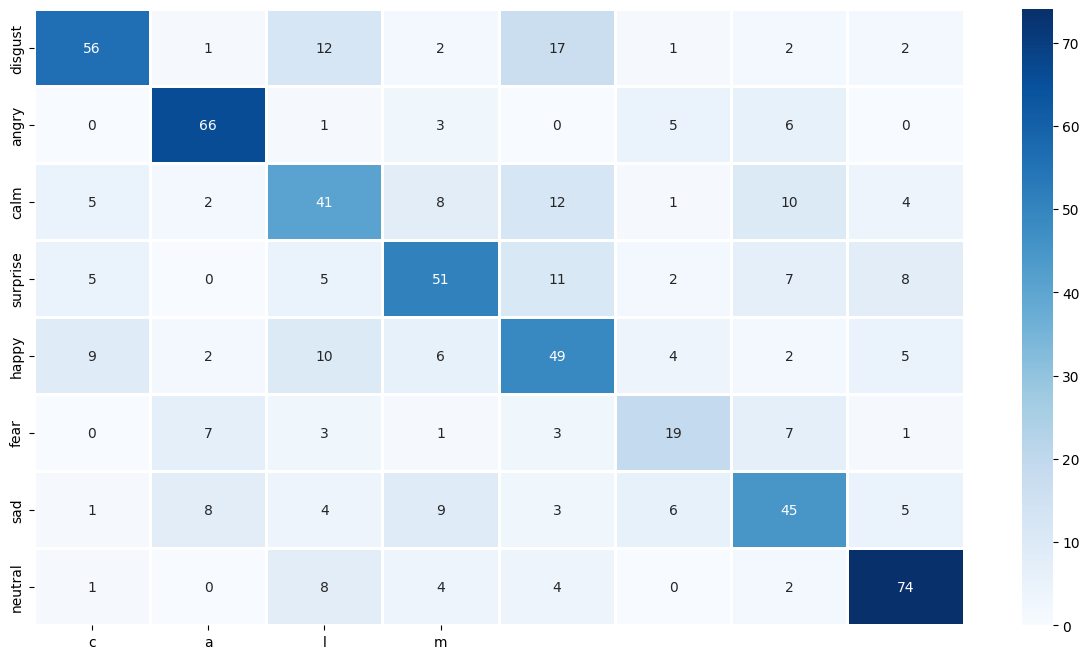

In [228]:
cm = confusion_matrix(Y_test, y_pred)

emotions = df['Actual Labels'].unique() # extrai as emoções que existem no dataset

plt.figure(figsize=(15,8))

sns.heatmap(cm, cmap='Blues', annot=True, linewidths=1, fmt='d', xticklabels=emotion, yticklabels=emotions)
plt.show()

In [229]:
# Use a função classification_report do sklearn para visualizar a precisão, recall e f1-score do modelo.
d = classification_report(Y_test, y_pred, output_dict=True) # retorna um dicionário 

d = pd.DataFrame(d).transpose() # transforma o dicionário em um dataset e transposta as linhas pelas colunas

print(d)

              precision    recall  f1-score     support
angry          0.727273  0.602151  0.658824   93.000000
calm           0.767442  0.814815  0.790419   81.000000
disgust        0.488095  0.493976  0.491018   83.000000
fear           0.607143  0.573034  0.589595   89.000000
happy          0.494949  0.563218  0.526882   87.000000
neutral        0.500000  0.463415  0.481013   41.000000
sad            0.555556  0.555556  0.555556   81.000000
surprise       0.747475  0.795699  0.770833   93.000000
accuracy       0.618827  0.618827  0.618827    0.618827
macro avg      0.610992  0.607733  0.608017  648.000000
weighted avg   0.621022  0.618827  0.618473  648.000000


### 4. Conclusão
- Podemos ver que nosso modelo é mais preciso na predição das emoções surpresa e raiva, o que faz sentido, pois os arquivos de áudio dessas emoções diferem bastante dos outros em aspectos como tom, velocidade, etc.
- No geral, alcançamos 62% de precisão nos dados de teste, o que é razoável, mas podemos melhorar ainda mais aplicando mais técnicas de aumento de dados e utilizando outros métodos de extração de features.

### 5. Salvando o Modelo e o Scaler

##### Passo 1: Salvando o Modelo
1. **Importação:** Use o `load_model` do Keras.
2. **Diretório:** Crie um diretório chamado `models` se não existir.
3. **Salvar:** Salve o modelo como no caminho especificado.

##### Passo 2: Salvando o Scaler
1. **Importação:** Use `joblib`.
2. **Diretório:** Utilize o mesmo caminho `models`.
3. **Salvar:** Salve o scaler.

In [230]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "models") 
os.makedirs(data_dir, exist_ok=True) # cria a pasta models se nao existir

pathModel = os.path.join(data_dir, 'audio_emotions_modelo.keras')
modelo.save(pathModel)

print(f'Modelo salvo em {pathModel}')

Modelo salvo em /home/vinicius/Desktop/miniprojeto2/models/audio_emotions_modelo.keras


In [231]:
import joblib

data_dir = os.path.join(os.path.dirname(os.getcwd()), "models")
os.makedirs(data_dir, exist_ok=True)

pathScaler = os.path.join(data_dir, "scaler.pkl")

joblib.dump(sc, pathScaler)

print(f'Arquivo salvo em {pathScaler}')

Arquivo salvo em /home/vinicius/Desktop/miniprojeto2/models/scaler.pkl
